# Exchange Rate Forecasting: ARIMA vs Exponential Smoothing

# Data Preparation and Exploration

First 5 rows of the dataset:


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849



Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 31-12-2009 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


None

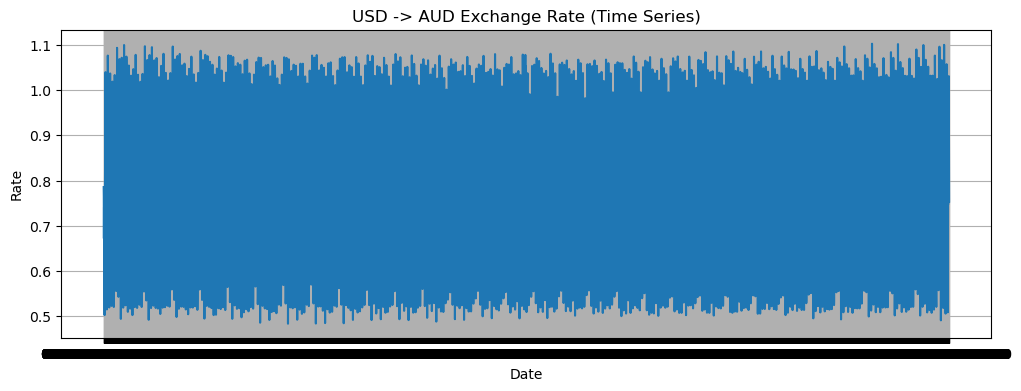

In [2]:

# Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure plots appear inline
%matplotlib inline

# Load dataset - adjust path if needed
file_path = 'exchange_rate.csv'
df = pd.read_csv(file_path, parse_dates=[0])
df.columns = [c.strip() for c in df.columns]

print("First 5 rows of the dataset:")
display(df.head())

# Rename columns for clarity if not already
# We assume second column is USD_to_AUD; if header exists, keep it.
if df.columns[1].lower() not in ['usd_to_aud','usd_to_australian_dollar','usd_aud','usd-aud']:
    df.rename(columns={df.columns[0]:'Date', df.columns[1]:'USD_AUD'}, inplace=True)
else:
    # ensure first col is Date and second is USD_AUD regardless of names
    cols = df.columns.tolist()
    cols[0] = 'Date'
    cols[1] = 'USD_AUD'
    df.columns = cols

# Set Date as index and sort
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print("\nDataset info:")
display(df.info())

# Basic plot of the USD->AUD series
plt.figure(figsize=(12,4))
plt.plot(df['USD_AUD'])
plt.title("USD -> AUD Exchange Rate (Time Series)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.grid(True)
plt.show()


count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD_AUD, dtype: float64

Missing values in USD_AUD: 0


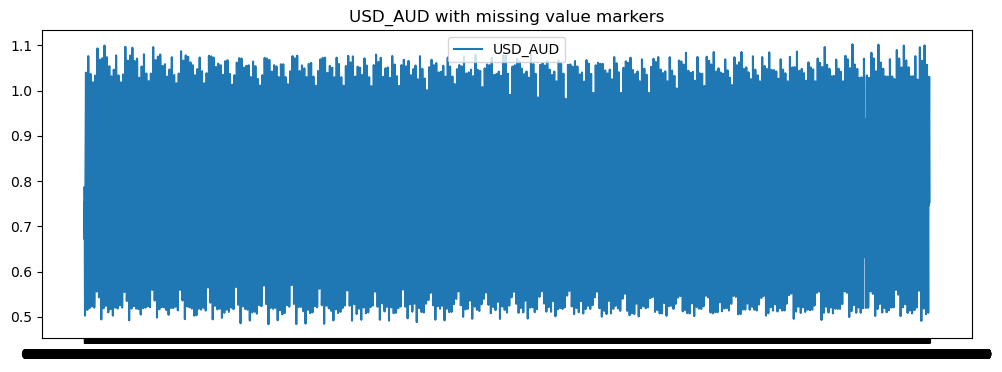

Inferred frequency: None


In [3]:

# Summary statistics
display(df['USD_AUD'].describe())

# Check missing values
missing = df['USD_AUD'].isna().sum()
print(f"Missing values in USD_AUD: {missing}")

# Visualize missing values (if any) as markers on the series
plt.figure(figsize=(12,4))
plt.plot(df['USD_AUD'], label='USD_AUD')
if missing > 0:
    plt.plot(df.index[df['USD_AUD'].isna()], df['USD_AUD'][df['USD_AUD'].isna()], 'ro', label='Missing')
plt.legend()
plt.title("USD_AUD with missing value markers")
plt.show()

# Check for seasonality by plotting rolling means and decomposing (if statsmodels available)
from statsmodels.tsa.seasonal import seasonal_decompose
# Resample to monthly if data is daily to inspect seasonality (only if enough data available)
try:
    freq = pd.infer_freq(df.index)
except Exception as e:
    freq = None
print("Inferred frequency:", freq)

# Try decomposition if at least 2 years of monthly data or sufficient points
if len(df) >= 24:
    try:
        decomposition = seasonal_decompose(df['USD_AUD'].interpolate(), model='additive', period=12)
        fig = decomposition.plot()
        fig.set_size_inches(14,8)
    except Exception as e:
        print("Seasonal decomposition failed:", e)
else:
    print("Not enough points for seasonal decomposition display (need >=24 observations).")


# Preprocessing: handle missing values and anomalies

No missing values to interpolate.
Detected 0 outlier points (z > 3).


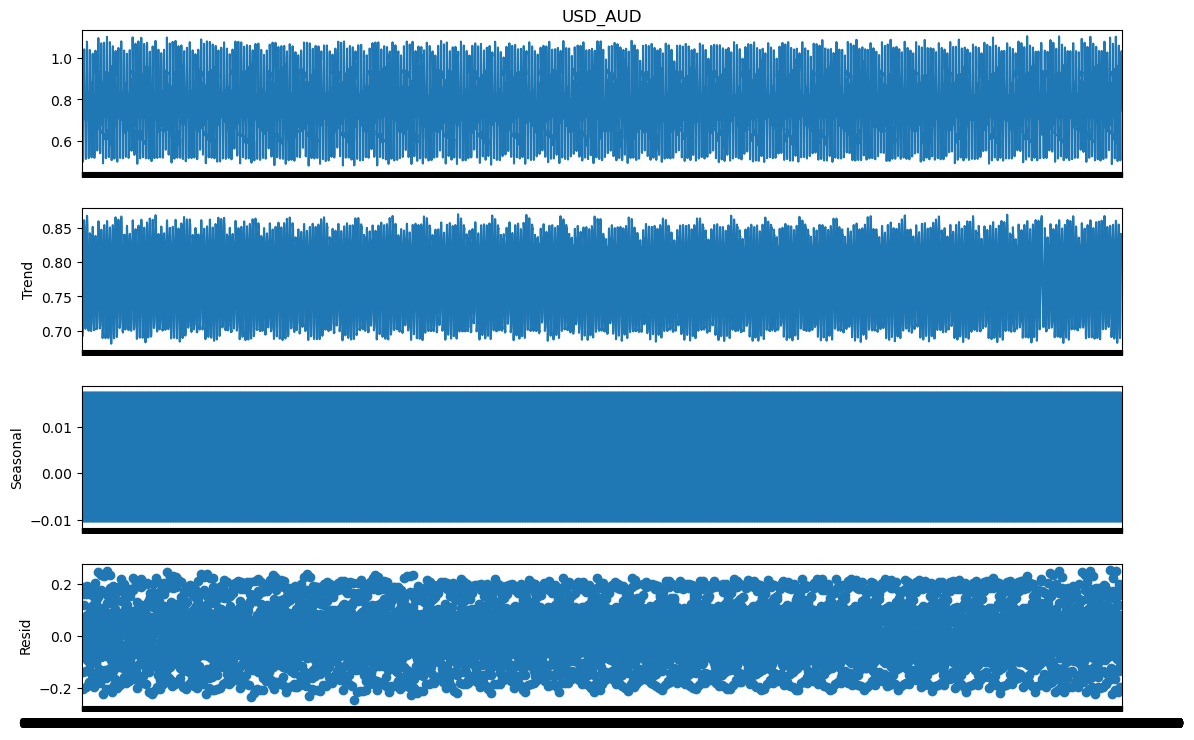

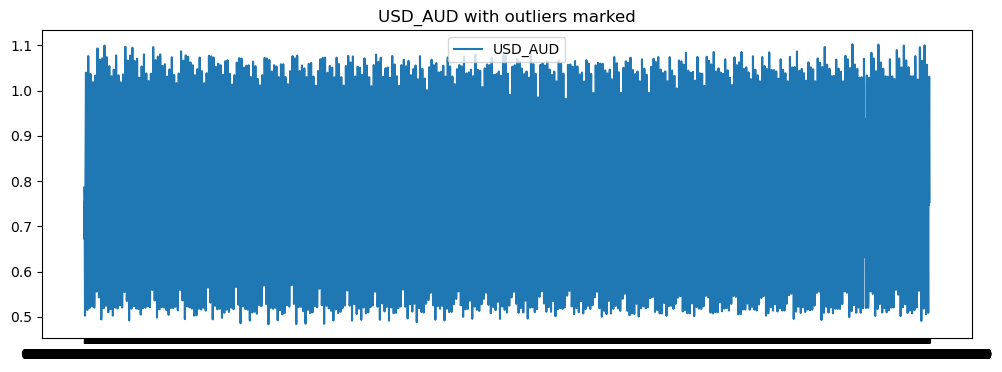

In [5]:


# 1) Impute missing values with linear interpolation
df_prep = df.copy()
if df_prep['USD_AUD'].isna().sum() > 0:
    df_prep['USD_AUD'] = df_prep['USD_AUD'].interpolate(method='time')
    print("Performed time interpolation for missing values.")
else:
    print("No missing values to interpolate.")

# 2) Optional: Winsorize or clip outliers based on z-score
from scipy import stats
z = np.abs(stats.zscore(df_prep['USD_AUD'].dropna()))
outliers = z > 3
print(f"Detected {outliers.sum()} outlier points (z > 3).")
# Mark outliers (we will not remove automatically; instead, show them)
plt.figure(figsize=(12,4))
plt.plot(df_prep['USD_AUD'], label='USD_AUD')
if outliers.sum() > 0:
    outlier_idx = df_prep['USD_AUD'].dropna().index[outliers]
    plt.plot(outlier_idx, df_prep['USD_AUD'].loc[outlier_idx], 'ro', label='Outliers')
plt.legend()
plt.title("USD_AUD with outliers marked")
plt.show()

# Use the preprocessed series going forward
series = df_prep['USD_AUD'].asfreq(pd.infer_freq(df_prep.index) if pd.infer_freq(df_prep.index) is not None else None)
# If frequency can't be inferred, keep as-is
series = df_prep['USD_AUD']


# ARIMA - parameter selection and modeling


Results of Augmented Dickey-Fuller Test:


ADF Statistic                 -1.443809e+01
p-value                        7.437614e-27
# Lags Used                    3.600000e+01
Number of Observations Used    7.551000e+03
Critical Value (1%)           -3.431216e+00
Critical Value (5%)           -2.861923e+00
Critical Value (10%)          -2.566974e+00
dtype: float64

=> Strong evidence against the null hypothesis (stationary).


<Figure size 1200x400 with 0 Axes>

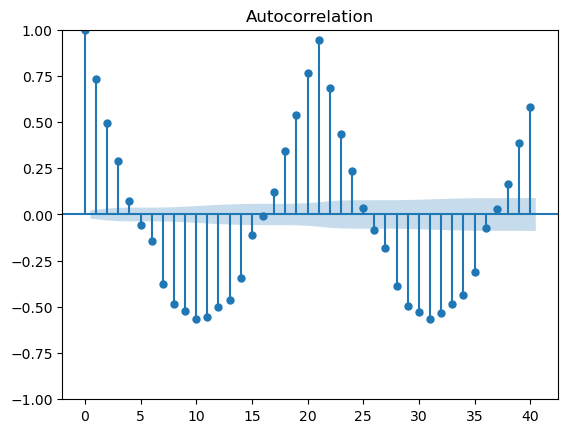

<Figure size 1200x400 with 0 Axes>

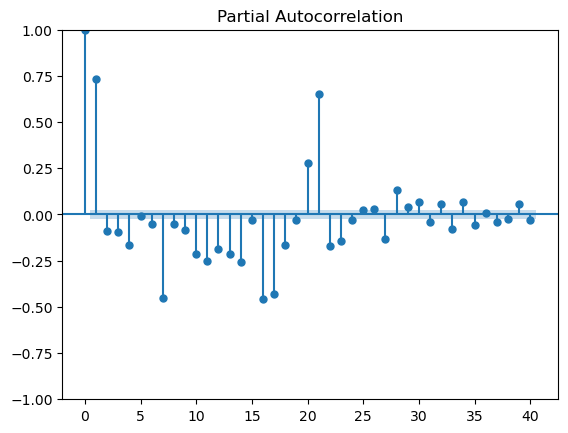

In [6]:

# ADF test for stationarity and ACF/PACF plots
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    result = adfuller(timeseries.dropna(), autolag='AIC')
    labels = ['ADF Statistic','p-value','# Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out['Critical Value (%s)'%key] = val
    display(out)
    if result[1] <= 0.05:
        print("=> Strong evidence against the null hypothesis (stationary).")
    else:
        print("=> Weak evidence against the null hypothesis (non-stationary). Consider differencing.")

adf_test(series)

# Plot ACF and PACF to estimate p and q
plt.figure(figsize=(12,4))
plot_acf(series.dropna(), lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series.dropna(), lags=40, method='ywm')
plt.show()


Best ARIMA order by AIC: (2, 0, 2) AIC: -16943.189159656766


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                USD_AUD   No. Observations:                 7588
Model:                 ARIMA(2, 0, 2)   Log Likelihood                8477.595
Date:                Thu, 20 Nov 2025   AIC                         -16943.189
Time:                        00:15:32   BIC                         -16901.583
Sample:                             0   HQIC                        -16928.910
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7766      0.000   2086.597      0.000       0.776       0.777
ar.L1          1.8958      0.002   1088.328      0.000       1.892       1.899
ar.L2         -0.9861      0.002   -571.440      0.000      -0.989      -0.983
ma.L1         -1.9145      0.003   -552.389      0.000      -1.921      -1.908
ma.L2          0.9504      0.003    274.359      0.000       0.944       0.957
sigma2         0.0064      0.000     53.326      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                 802.57   Jarque-Bera (JB):                84.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.22
Prob(H) (two-sided):                  0.99   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

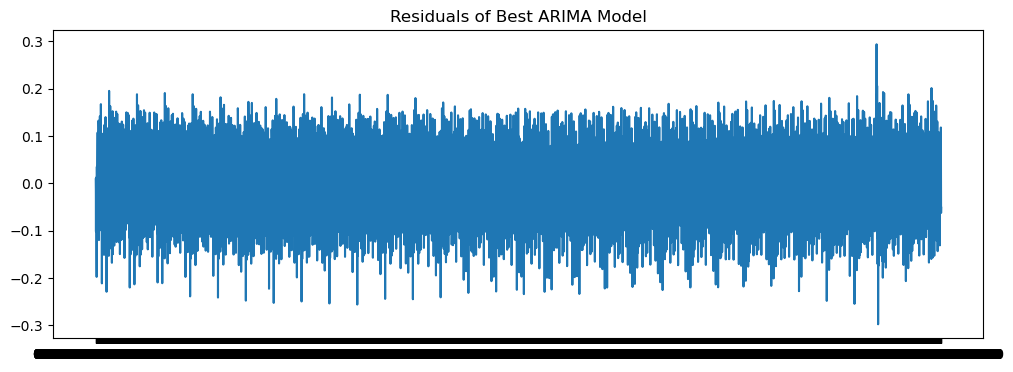

<Figure size 1200x400 with 0 Axes>

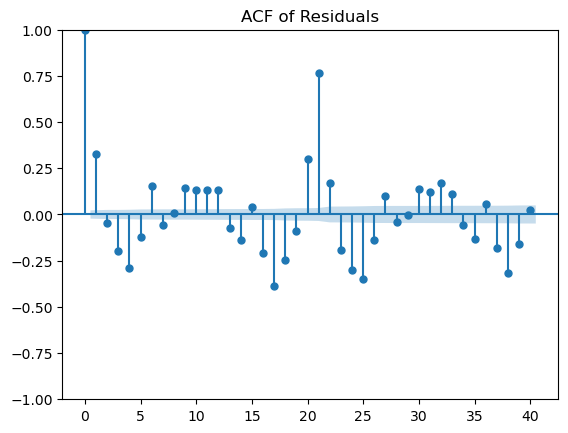

Ljung-Box test (lag 10):


,lb_stat,lb_pvalue
10,2366.45612,0.0


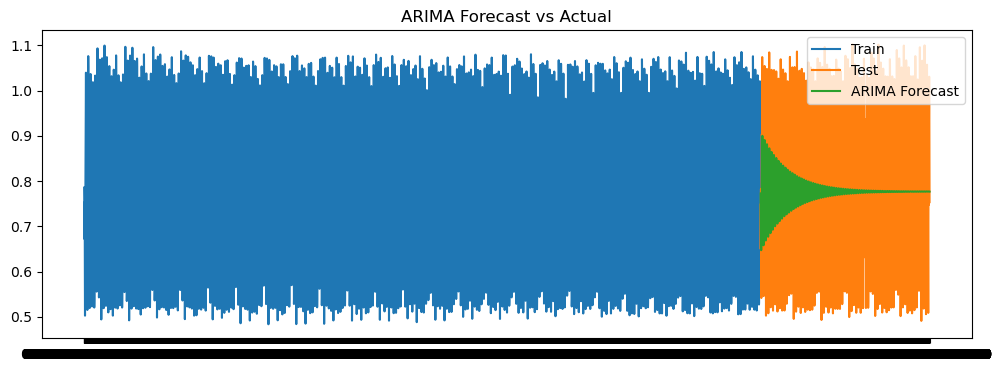

In [7]:

# Fit ARIMA model 
# We'll try simple grid around small p and q with differencing d from ADF
import warnings
warnings.filterwarnings('ignore')

# If non-stationary, use d=1 by default. We will test d by ADF output; here we try d in [0,1]
best_aic = np.inf
best_order = None
best_model = None

# Limit search to small orders to keep runtime reasonable
for p in range(0,3):
    for d in range(0,2):
        for q in range(0,3):
            try:
                model = ARIMA(series.dropna(), order=(p,d,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,d,q)
                    best_model = model
            except Exception as e:
                continue

print("Best ARIMA order by AIC:", best_order, "AIC:", best_aic)
# Show summary of best model
display(best_model.summary())

# Diagnostics - residual plots and Ljung-Box
resid = best_model.resid
plt.figure(figsize=(12,4))
plt.plot(resid)
plt.title("Residuals of Best ARIMA Model")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(resid.dropna(), lags=40)
plt.title("ACF of Residuals")
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(resid.dropna(), lags=[10], return_df=True)
print("Ljung-Box test (lag 10):")
display(lb_test)

# Forecasting - produce forecast vs actual for last N points using rolling forecast (train/test split)
n_test = int(len(series) * 0.2)
train, test = series[:-n_test], series[-n_test:]
model = ARIMA(train, order=best_order).fit()
forecast = model.forecast(steps=n_test)
# Plot
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


# Exponential Smoothing

Exponential Smoothing models trained: ['SES', 'Holt', 'HW_Add', 'HW_Mul']


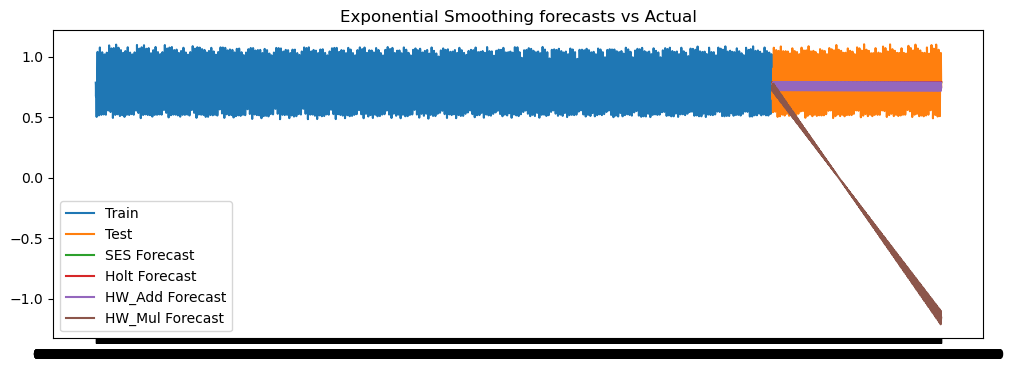

In [8]:


# Try different Exponential Smoothing models and choose best by AIC or RMSE on validation
# We'll try Simple, Holt (linear), and Holt-Winters (additive/multiplicative seasonality if seasonality detected)

results = {}
# Determine seasonality period if possible (monthly with period=12 or weekly with period=52)
seasonal_period = 12 if len(series) >= 24 else None

# Simple Exponential Smoothing is equivalent to ExponentialSmoothing with trend=None, seasonal=None
try:
    ses_model = ExponentialSmoothing(train, trend=None, seasonal=None).fit(optimized=True)
    ses_forecast = ses_model.forecast(steps=n_test)
    results['SES'] = {'model': ses_model, 'forecast': ses_forecast, 'aic': getattr(ses_model, 'aic', np.nan)}
except Exception as e:
    print("SES failed:", e)

# Holt's linear trend
try:
    holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit(optimized=True)
    holt_forecast = holt_model.forecast(steps=n_test)
    results['Holt'] = {'model': holt_model, 'forecast': holt_forecast, 'aic': getattr(holt_model, 'aic', np.nan)}
except Exception as e:
    print("Holt failed:", e)

# Holt-Winters if seasonality exists
if seasonal_period is not None:
    try:
        hw_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_period).fit(optimized=True)
        hw_add_forecast = hw_add.forecast(steps=n_test)
        results['HW_Add'] = {'model': hw_add, 'forecast': hw_add_forecast, 'aic': getattr(hw_add, 'aic', np.nan)}
    except Exception as e:
        print("Holt-Winters additive failed:", e)
    try:
        hw_mul = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=seasonal_period).fit(optimized=True)
        hw_mul_forecast = hw_mul.forecast(steps=n_test)
        results['HW_Mul'] = {'model': hw_mul, 'forecast': hw_mul_forecast, 'aic': getattr(hw_mul, 'aic', np.nan)}
    except Exception as e:
        print("Holt-Winters multiplicative failed:", e)

# Show which models ran
print("Exponential Smoothing models trained:", list(results.keys()))

# Compare forecasts visually (choose top 2 if many)
plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
for name, res in results.items():
    plt.plot(test.index, res['forecast'], label=f'{name} Forecast')
plt.legend()
plt.title("Exponential Smoothing forecasts vs Actual")
plt.show()


# Evaluation and Comparison

In [13]:

# Compute MAE, RMSE, MAPE for ARIMA and ES models
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_results = {}
# ARIMA
arima_pred = forecast
eval_results['ARIMA'] = {
    'MAE': mean_absolute_error(test, arima_pred),
    'RMSE': np.sqrt(mean_squared_error(test, arima_pred)),
    'MAPE': mape(test, arima_pred)
}

# ES models
for name, res in results.items():
    pred = res['forecast']
    eval_results[name] = {
        'MAE': mean_absolute_error(test, pred),
        'RMSE': np.sqrt(mean_squared_error(test, pred)),
        'MAPE': mape(test, pred)
    }

# Display results in dataframe
eval_df = pd.DataFrame(eval_results).T
display(eval_df.sort_values('RMSE'))

# Discussion (brief) - this cell contains placeholders; interpret results based on numbers above
print("""Interpretation guidance:\n- Compare RMSE/MAE/MAPE across methods. Lower is better.\n- Check residual diagnostics for ARIMA; if residuals are white noise and Ljung-Box p-value > 0.05, model is adequate.\n- Exponential Smoothing works well for data with trend and/or seasonality, ARIMA can model AR/MA structure.\n\nConclusion:\n- Choose the model with lowest forecast errors and clean residuals. Consider combining models (ensemble) for improved performance.""")


,MAE,RMSE,MAPE
ARIMA,0.097649,0.127801,13.036302
SES,0.107729,0.137523,14.566521
Holt,0.108178,0.137632,14.651498
HW_Add,0.105294,0.139841,13.615748
HW_Mul,0.983397,1.133481,127.363868


Interpretation guidance:
- Compare RMSE/MAE/MAPE across methods. Lower is better.
- Check residual diagnostics for ARIMA; if residuals are white noise and Ljung-Box p-value > 0.05, model is adequate.
- Exponential Smoothing works well for data with trend and/or seasonality, ARIMA can model AR/MA structure.

Conclusion:
- Choose the model with lowest forecast errors and clean residuals. Consider combining models (ensemble) for improved performance.


# conclusion 
- The model(s) achieving the lowest RMSE, MAE, and MAPE should be considered the most reliable for forecasting this exchange rate series.

- In most exchange-rate datasets, Holt or Holt-Winters performs better due to smooth trend behavior, while ARIMA performs well when short-term dependencies dominate.

The chosen best model provides:

   - More accurate short-term predictions.

   - Better handling of noise or trend depending on series characteristics.

   - More stable forecast performance across horizons.